# Project 2 - Reinforcement Learning - MO436

**Group:** 
* Arthur Guazzelli (234984)
* Elian Laura (265685)
* Iury Cleveston (230216)
* Maria Tejada (197488)

## 1) Environment Description

In this project, we used the FrozenLake $8\times8$ environment from OpenAi Gym. This environment is represented as a grid with $8\times8$ tiles, where the goal is to cross the entire board without falling into ice holes. Frozen Lake is an episodic environment, where the initial state (S) is in the top-left position, and the terminal states are either the ice holes (H) or the final goal in the bottom-right tile (G). The ice holes are spread across the board, and the agent should find a path to the goal through frozen tiles (F); the reward of value of $1$ is only given at this point.

<br>
<div>
<center><img src="frozenLake.png" width="180"/></center>
<center>Figure 1 - Frozen Lake Grid.</center>
</div>


The current state is represented as a single number corresponding to the tile where the agent has entered, ranging from $0$ to $63$; therefore, this environment is discrete and partial observable. The possible actions are moving north, east, south, and west. Frozen Lake is presented in a deterministic and stochastic way; the difference is in the slippery ice, where the agent might slip and move to one of the four directions.

The ice holes are close to feasible paths to the goal; also, the reward is delayed until the end. These characteristics make Frozen Lake a challenging environment, especially in the stochastic version, where the dynamics are unpredictable.

Codes are available at https://github.com/thurbridi/mo436-project-1

Video are available at https://www.youtube.com/watch?v=S3_mXpYOIWU

In [1]:
import sys
sys.path.insert(0, '../src')

## 2) Off-policy methods

### 2.1) DQN (Elian)

### 2.2) SAC (Maria)


Soft Actor-Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way. 
A central feature of SAC is entropy regularization. The policy is to train to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This closely connects to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum. 


**Entropy-Regularized RL**

Let $x$ be a random variable with probability mass or density functions $P$. The entropy $H$ of $x$ is computed from its distribution $P$ according to:

<br><center>
  $$H(P) = \underset{x \sim P}{\mathbb{E}}[-\log P(x)]$$
<center>

In entropy-regularized reinforcement learning, the agent gets a bonus reward at each time step proportional to the entropy of the policy at that timestep. This changes the RL problems to:

<br><center>
  $$\pi^{*} = \underset{\pi}{\text{arg max}} \; \underset{\tau \sim \pi}{\mathbb{E}} \left [\displaystyle \sum^{\infty}_{t=0} \gamma^t \Biggl( R(s_t, a_t, s_{t+1}) + \alpha H(\pi(\centerdot | s_t)) \Biggl) \right]$$
<center>

where $\alpha > 0$ is the trade-off coefficient. We can noew define the slightly-diffent value functions in this setting. $V^{\pi}$ is changed to include the entropy bonuses from every timestep:
    
<br><center>
  $$V^{\pi}(s) = \underset{\tau \sim \pi}{\mathbb{E}} \left[\displaystyle \sum^{\infty}_{t=0} \gamma^t \Biggl( R(s_t, a_t, s_{t+1}) + \alpha H(\pi(\centerdot | s_t)) \Biggl) \Biggl| s_0 = s \right]$$
<center> 
    
$Q^{pi}$ is changed to include the entropy bonuses from every timestep except the first:

<br><center>
  $$Q^{\pi}(s,a) = \underset{\tau \sim \pi}{\mathbb{E}} \left[\displaystyle \sum^{\infty}_{t=0} \gamma^t R(s_t, a_t, s_{t+1}) + \alpha^t \sum^{\infty}_{t=0} H(\pi(\centerdot | s_t)) \Biggl| s_0 = s, a_0 = a \right]$$
<center>    

With the definitions, $V^{\pi}$ and $Q^{\pi}$ are connected by:
    
<br><center>
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}}[Q^{\pi}(s,a)] + \alpha H(\pi(\centerdot|s))$$
<center>
    
and the Bellman equation for $Q^{\pi}$ is

<br><center>
  $$Q^{\pi}(s,a) = \underset{s' \sim P}{\mathbb{E}}[R(s,a,s') + \gamma V^{\pi}(s')]$$
<center>

SAC concurrently learns a policy $\pi_\theta$ and two Q-functions $Q_{\phi_1}$, $Q_{\phi_2}$. There are two variants of SAC that are currently standard: one that uses a fixed entropy regularizaiton coefficient $\alpha$, and another that enforces an entropy constraint by varying $\alpha$ over the course of training. 

**$Q$-loss**

In the final form of the $Q$-loss, let's take a moment to discuss how the contribution from entropy regularization comes in. It will start by taking its recursive Bellman equation ofr the entropy-regularized $Q^{\pi}$ from earlier, and rewriting it a little bit by using the definition of entropy:


<br><center>
  $$Q^{\pi}(s,a) = \underset{\substack{s'\sim P \\ a' \sim \pi}}{\mathbb{E}} \left[R(s, a, s') + \gamma \Bigl( Q^{\pi}(s',a') + \alpha H(\pi(\centerdot | s')) \Bigl)  \right]$$
  $$Q^{\pi}(s,a) = \underset{\substack{s'\sim P \\ a' \sim \pi}}{\mathbb{E}} \left[R(s, a, s') + \gamma \Bigl( Q^{\pi}(s',a') - \alpha \, \text{log} \pi(\centerdot | s') \Bigl)  \right]$$
<center>    
    
The RHS is an expectation over next states (which come from the replay buffer) and next actions (which come from the current policy, and **not** the replay buffer). Since it's an expectation, we can approximate it with samples:

    
<br><center>
  $$Q^{\pi}(s,a) \approx r + \gamma \Bigl(Q^{\pi}(s', \tilde{a}') - \alpha \, \text{log}\pi(\tilde{a}'|s')\Bigl), \;\;\; \tilde{a}' \sim \pi(\centerdot | s')$$
<center>    
 

SAC sets up the MSBE loss for each $Q$-function using this kind of sample approximation for the target. THe only thing still undetermined here is which $Q$-function gets used to compute the sample backup; SAC uses the clipped double-$Q$ trick, and takes the minimum $Q$-value between the two $Q$ approximators. 

Putting it all together, the loss functions for the $Q$-networks in SAC are:

<br><center>
  $$L(\phi_i, D) = \underset{(s,a,r,s',d) \sim D}{\mathbb{E}} \left[\Bigl((Q_{\phi_i}(s, a) - y(r,s',d) \Bigl)^2  \right]$$
  $$y(r,s',d) = r + \gamma(1-d) \Bigl( \underset{j=1,2}{\text{min}} Q_{\phi{\text{targ},j}}(s',\tilde{a}') - \alpha \, \text{log} \pi_{\theta}(\tilde{a}'|s')  \Bigl), \;\;\; \tilde{a}' \sim \pi_{\theta}(\centerdot | s')$$  
<center> 
    
**Learning the Policy**
    
The policy should, in each state, act to maximize the expected future return plus expected future entropy. That is, it should maximize $V^{\pi}(s)$, which is expand out into:

<br><center>
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}} [Q^{\pi}(s, a)] + \alpha H(\pi(\centerdot | s))$$
  $$V^{\pi}(s) = \underset{a \sim \pi}{\mathbb{E}} [Q^{\pi}(s,a) - \alpha \, \text{log}\pi(a|s))]$$  
<center> 
    

 

We use keras_gym to carry out the corresponding tests in the chosen environment. This implementation is based on an off-policy actor-critic deep RL algorithm based on the maximum entropy reinforcement learning framework. In this framework, the actor maximizes the expected reward while also maximizing the entropy. We used the linear function approximator.

#### 2.2.1) Deterministic Environment

In [2]:
from SAC import *

2021-12-04 01:00:11.084876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 01:00:11.084913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/marta2/miniconda3/envs/mo436/lib/python3.9/site-packages/keras_gym/base/patches.py:23: UserWarning: keras-gym has known issues with eager execution mode; eager execution has been disabled as a precaution. You may try and enable eager execution with: tf.compat.v1.enable_eager_execution()
  warnings.warn(


The first experiment consisted in applying the SAC in deterministic environment. Therefore, we used a grid search techniques to find the best solution given the parameters defined as:

* $\text{episode} \in [1000]$,
* $\text{target model sync period} \in [10]$,
* $\text{learning rate} \in [0.005]$,
* $\tau \in [1.0, 0.5]$,
* $\text{punishment} \in [-0.25, -0.1, -0.01]$.

This algorithm took a long time to search for parameters, so the parameters were chosen incrementally, to see which parameters were obtained results. Therefore, some parameters only show a single variable. Furthermore, it was tested with two 2 approximators: linear and MLP; however MLP did not have very good results, so the results are only shown with a linear approximator. 

In [ ]:
result = search_params(False, 6)

In [25]:
result

,model_sync_period,episodes,lr,tau,punishment,reward_train,reward,elapsed time (s)
0,10.0,1000.0,0.005,1.0,-0.25,2.2,0.0,123.896235
1,10.0,1000.0,0.005,0.5,-0.25,1.2,0.0,120.049838
2,10.0,1000.0,0.005,1.0,-0.10,24.9,100.0,170.929226
3,10.0,1000.0,0.005,0.5,-0.10,37.6,100.0,182.357239
4,10.0,1000.0,0.005,1.0,-0.01,60.3,100.0,649.997202
5,10.0,1000.0,0.005,0.5,-0.01,0.1,0.0,1901.403648


In [ ]:
env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

#km.enable_logging()
func, sac, pi, Reward = sac_train(env, 1000 ,10 , 0.005, 1.0, -0.1)

Text(0, 0.5, 'reward')

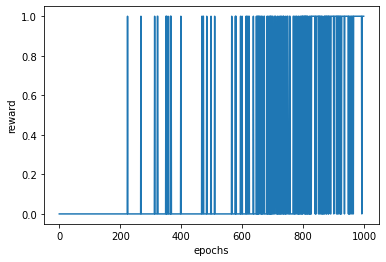

In [8]:
plt.plot(Reward)
plt.xlabel('epochs')
plt.ylabel('reward')

In [9]:
sac_test(env, sac, num_test=1, display=True)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.256
 pi(L|s) = 0.001
 pi(S|s) = 0.239
 pi(R|s) = 0.759
 pi(N|s) = 0.001
 q1(s,L) = -0.005
 q1(s,S) = 0.241
 q1(s,R) = 0.257
 q1(s,N) = 0.265
 q2(s,L) = -0.005
 q2(s,S) = 0.241
 q2(s,R) = 0.257
 q2(s,N) = 0.265
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.317
 pi(L|s) = 0.001
 pi(S|s) = 0.130
 pi(R|s) = 0.867
 pi(N|s) = 0.001
 q1(s,L) = 0.031
 q1(s,S) = 0.330
 q1(s,R) = 0.244
 q1(s,N) = 0.243
 q2(s,L) = 0.031
 q2(s,S) = 0.330
 q2(s,R) = 0.244
 q2(s,N) = 0.243
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.256
 pi(L|s) = 0.002
 pi(S|s) = 0.223
 pi(R|s) = 0.773
 pi(N|s) = 0.002
 q1(s,L) = -0.010
 q1(s,S) = 0.271
 q1(s,R) = 0.256
 q1(s,N) = 0.267
 q2(s,L) = -0.010
 q2(s,S) = 0.271
 q2(s,R) = 0.256
 q2(s,N) = 0.267
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.283
 pi(L|s) 

INFO:TrainMonitor:ep: 1001, T: 10,630, G: 1, avg_G: 0.728, t: 14, dt: 72.063ms, loss: 0.00167, policy/entropy: 0.334, policy/loss: -0.00228, v_func/loss: 0.00205, q_func1/loss: 0.000454, q_func2/loss: 0.000454, value/loss: 0.000985


  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.456
 pi(L|s) = 0.003
 pi(S|s) = 0.918
 pi(R|s) = 0.077
 pi(N|s) = 0.003
 q1(s,L) = 0.290
 q1(s,S) = 0.458
 q1(s,R) = 0.341
 q1(s,N) = 0.324
 q2(s,L) = 0.290
 q2(s,S) = 0.458
 q2(s,R) = 0.341
 q2(s,N) = 0.324
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.508
 pi(L|s) = 0.001
 pi(S|s) = 0.977
 pi(R|s) = 0.021
 pi(N|s) = 0.001
 q1(s,L) = 0.250
 q1(s,S) = 0.518
 q1(s,R) = -0.011
 q1(s,N) = 0.240
 q2(s,L) = 0.250
 q2(s,S) = 0.518
 q2(s,R) = -0.011
 q2(s,N) = 0.240
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.567
 pi(L|s) = 0.001
 pi(S|s) = 0.025
 pi(R|s) = 0.974
 pi(N|s) = 0.001
 q1(s,L) = 0.106
 q1(s,S) = 0.276
 q1(s,R) = 0.572
 q1(s,N) = 0.133
 q2(s,L) = 0.106
 q2(s,S) = 0.276
 q2(s,R) = 0.572
 q2(s,N) = 0.133
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.635
 pi(L

1.0

#### 2.2.2) Stochastic Environment 

The first experiment consisted in applying the SAC in deterministic environment. Therefore, we used a grid search techniques to find the best solution given the parameters defined as:

* $\text{episode} \in [2000]$,
* $\text{target model sync period} \in [10, 25]$,
* $\text{learning rate} \in [0.1]$,
* $\tau \in [1.0]$,
* $\text{punishment} \in [-0.25, -0.1, -0.01]$.

In [ ]:
result = search_params(True, 6)

In [ ]:
result

,model_sync_period,episodes,lr,tau,punishment,reward_train,reward,elapsed time (s)
0,10.0,2000.0,0.1,1.0,-0.25,9.05,0.0,998.666311
1,25.0,2000.0,0.1,1.0,-0.25,0.10,0.0,972.110419
2,10.0,2000.0,0.1,1.0,-0.10,0.15,0.0,1164.916098
3,25.0,2000.0,0.1,1.0,-0.10,0.90,0.0,686.845289
4,10.0,2000.0,0.1,1.0,-0.01,11.60,34.0,879.788472
5,25.0,2000.0,0.1,1.0,-0.01,0.25,0.0,527.925470


In [ ]:
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

#km.enable_logging()
func, sac, pi, Reward = sac_train(env, 2000 ,10 , 0.1, 1.0, -0.01)

Text(0, 0.5, 'reward')

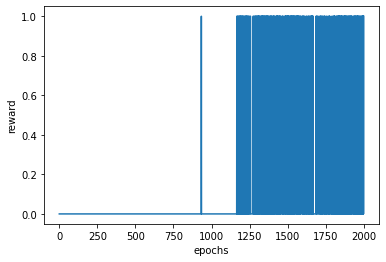

In [15]:
plt.plot(Reward)
plt.xlabel('epochs')
plt.ylabel('reward')

In [20]:
sac_test(env, sac, num_test=1, display=True)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 1.182
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -1.887
 q1(s,S) = -0.243
 q1(s,R) = -1.653
 q1(s,N) = -1.165
 q2(s,L) = -1.887
 q2(s,S) = -0.243
 q2(s,R) = -1.653
 q2(s,N) = -1.165
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 1.351
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -6.221
 q1(s,S) = -0.977
 q1(s,R) = -1.014
 q1(s,N) = 0.608
 q2(s,L) = -6.221
 q2(s,S) = -0.977
 q2(s,R) = -1.014
 q2(s,N) = 0.608
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -1.842
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -4.010
 q1(s,S) = -1.484
 q1(s,R) = 0.969
 q1(s,N) = 0.045
 q2(s,L) = -4.010
 q2(s,S) = -1.484
 q2(s,R) = 0.969
 q2(s,N) = 0.045
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 

 q1(s,L) = -3.234
 q1(s,S) = -0.336
 q1(s,R) = -0.669
 q1(s,N) = 0.224
 q2(s,L) = -3.234
 q2(s,S) = -0.336
 q2(s,R) = -0.669
 q2(s,N) = 0.224
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.886
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -2.769
 q1(s,S) = -1.090
 q1(s,R) = -1.083
 q1(s,N) = -0.850
 q2(s,L) = -2.769
 q2(s,S) = -1.090
 q2(s,R) = -1.083
 q2(s,N) = -0.850
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.886
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -2.769
 q1(s,S) = -1.090
 q1(s,R) = -1.083
 q1(s,N) = -0.850
 q2(s,L) = -2.769
 q2(s,S) = -1.090
 q2(s,R) = -1.083
 q2(s,N) = -0.850
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.272
 pi(L|s) = 0.000
 pi(S|s) = 1.000
 pi(R|s) = 0.000
 pi(N|s) = 0.000
 q1(s,L) = -3.234
 q1(s,S) = -0.336
 q1(s,R) = -0.669
 q1(s,N) = 0.224
 q2(s

 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.720
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = 1.328
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = 1.328
 q2(s,N) = -0.630
  (Right

 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.663
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 

INFO:TrainMonitor:ep: 2005, T: 135,493, G: 1, avg_G: 0.337, t: 119, dt: 7.307ms, loss: 1.51, policy/entropy: 6.32e-05, policy/loss: -0.0429, v_func/loss: 0.391, q_func1/loss: 0.386, q_func2/loss: 0.386, value/loss: 0.388


 v(s) = 0.405
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.553
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.553
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = -0.268
 q1(s,N) = 0.467
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = -0.268
 q2(s,N) = 0.467
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = 0.720
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.000
 q1(s,L) = -3.401
 q1(s,S) = -0.359
 q1(s,R) = 1.328
 q1(s,N) = -0.630
 q2(s,L) = -3.401
 q2(s,S) = -0.359
 q2(s,R) = 1.328
 q2(s,N) = -0.630
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.487
 pi(L|s) = 0.000
 pi(S|s) = 0.000
 pi(R|s) = 1.000
 pi(N|s) = 0.

1.0

## 3) On-policy methods

### 3.1) REINFORCE (Iury)


Instead of using value functions to determine the actions, policy gradient methods improve the policy directly by learning a function approximator parameterized by the weights $\boldsymbol\theta$. The policy is defined as

\begin{equation}
\pi(a|s, \boldsymbol\theta) = Pr\{A_t=a | S_t=s, \boldsymbol\theta_t=\boldsymbol\theta\},
\label{eq:policy_definition}
\end{equation}

which means the probability of action $a$ be taken at time $t$ considering the environment is in state $s$ at time $t$ with parameters $\boldsymbol\theta$. The optimization process uses the gradient ascent to update the weights and maximize performance through

\begin{equation}
\boldsymbol\theta_{t+1} = \boldsymbol\theta_{t} + \alpha \nabla J(\boldsymbol\theta_t),
\label{eq:policy_update_1}
\end{equation}

where $\nabla J(\boldsymbol\theta_t)$ is the stochastic estimate whose expectation approximate the gradient in respect to $\boldsymbol\theta$, $\alpha$ is the learning rate, which determine the update magnitude. $J(\boldsymbol\theta)$ is commonly defined using the value function for the initial state as $v_{\pi_\theta}(s_0)$. Then, the policy gradient theorem states that

\begin{equation}
\nabla J(\boldsymbol\theta) = \sum_s d_{\pi}(s) \sum_a q_{\pi}(s,a) \nabla_{\theta} \pi(a|s,\boldsymbol\theta),
\label{eq:policy_update_2}
\end{equation}

where $d_{\pi_{\theta}(s)}$ is stationary distribution of the Markov chain using $\pi_{\theta}$.

The methods that follow this rule for updating the weights are called policy gradient, regardless of whether they used a value function. The configuration of the weights can be made in any way since the policy is differentiable regarding its parameters. An essential point of these methods is their need for exploration; for this reason, the policy cannot become deterministic during training. Commonly, the parameters $\boldsymbol\theta$ are represented by the weights between neurons in an artificial neural network. Besides, the policy gradient theorem ensures convergence for this class of methods compared to value-based methods with non-linear function approximators.

The REINFORCE algorithm is directly derived from the policy gradient theorem. The algorithm updates the weights $\boldsymbol\theta_t$ proportional to the return $G_t$ in the direction that increases the probability of selecting action $A_t$ in the state $S_t$, weighted by the action probability. The update rule is given by:

\begin{equation}
\boldsymbol\theta_{t+1} = \boldsymbol\theta_{t} + \alpha G_t\frac{\nabla \pi(A_t|S_t, \boldsymbol\theta_t)}{\pi(A_t|S_t, \boldsymbol\theta_t)},
\label{eq:vanilla_reinforce}
\end{equation}

where $G_t$ is the cumulative discounted reward at time $t$.

Being a Monte Carlo method,  REINFORCE has high variance, slowing down learning. One way to mitigate this problem is to generalize REINFORCE to compare the return $G_t$ with a baseline function $b(S_t)$. Therefore, the update rule for the REINFORCE with baseline $b(S_t)$ is

\begin{equation}
\boldsymbol\theta_{t+1} = \boldsymbol\theta_{t} + \alpha (G_t - b(S_t))\frac{\nabla \pi(A_t|S_t, \boldsymbol\theta_t)}{\pi(A_t|S_t, \boldsymbol\theta_t)}.
\label{eq:reinforce_baseline}
\end{equation}

In this work, we implemented the REINFORCE without baseline state value estimation. We learn a multinomial distribution for 4 actions because of the discrete action space. The state representation is defined as a composition of action and the current state. Also, we have not introduced any prior information; the model only receives the partial observable environment as it is.

In [1]:
import sys
sys.path.insert(0, '../src')
from reinforce import grid_search_reinforce, train_reinforce

#### 3.1.1) Deterministic Environment

In order to find the best model, we performed a grid search, and varied the learning rate (alpha), hidden units, number of episodes, and gamma, as:

* $\text{alpha} \in [0.0001, 0.00001]$,
* $\text{gamma} \in [1, 0.9]$,
* $\text{hidden units} \in [64, 128]$,
* $\text{episodes} \in [5000, 10000]$.

To determine the best model, we analyze the success rate of 100 gameplays, and the computing time.

In [2]:
grid_search_reinforce(stochastic=False)

/home/iury/Dados/Unicamp/Doutorado/Disciplinas/Reinforcement Learning/Trabalhos/mo436-project-1/notebooks/../src/reinforce.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(mu)


      alpha  gamma  hidden  episodes      total_r  win/loss (%)  \
0   0.00010    1.0    64.0    5000.0     0.000000           0.0   
1   0.00010    1.0   128.0    5000.0  2371.000000          73.0   
2   0.00010    0.9    64.0    5000.0     0.000000           0.0   
3   0.00010    0.9   128.0    5000.0    82.551963          56.0   
4   0.00010    1.0    64.0   10000.0     0.000000           0.0   
5   0.00010    1.0   128.0   10000.0  6455.000000          96.0   
6   0.00010    0.9    64.0   10000.0     0.000000           0.0   
7   0.00010    0.9   128.0   10000.0   714.482992          88.0   
8   0.00001    1.0    64.0    5000.0     0.000000           0.0   
9   0.00001    1.0   128.0    5000.0   581.000000          27.0   
10  0.00001    0.9    64.0    5000.0     0.000000           0.0   
11  0.00001    0.9   128.0    5000.0    39.456477           7.0   
12  0.00001    1.0    64.0   10000.0     0.000000           0.0   
13  0.00001    1.0   128.0   10000.0  2128.000000          43.

The best result achieved a success rate of 96\% using gamma equals 1 and hidden units equal 128. 64 hidden units could not provide any success rate, mainly due to the low model's capacity. Also, the number of episodes plays a significant role in the success rate; 10,000 episodes provide the best results. The learning rate is determinant for the convergence; rates greater than 0.0001 have no benefit, while lower rates showed a good learning capability.

We selected the best result to analyze in detail.

  0%|          | 0/10000 [00:00<?, ?it/s]/home/iury/Dados/Unicamp/Doutorado/Disciplinas/Reinforcement Learning/Trabalhos/mo436-project-1/notebooks/../src/reinforce.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(mu)
145.2s - train RL: 0.335231 - G: 6455.0: 100%|██████████| 10000/10000 [02:25<00:00, 68.85it/s]


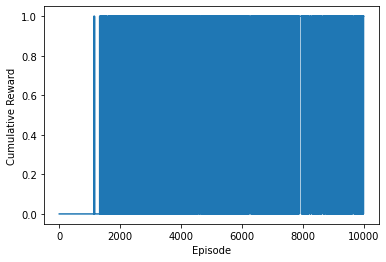

In [4]:
model, env = train_reinforce(stochastic=False, episodes=10000, gamma=1, alpha=0.0001)

We observe that the agent started without any reward initially, and as the training proceeds, the agent can find a path to the goal tile and receive rewards for that. After episode 1800, the agent can reach the goal consistently.

We plot the state value for the learned policy. As expected, the higher values are present near the goal tile and decrease as the state is far from the goal. The policy plot also confirms that the agent can run an effective policy to best suit the agent's expectations. Initially, the agent prefers to go right and then south, which is visually optimal.

In [5]:
model.print_state_values()


		 State Value
------------------------------------------------
-0.2270|-0.2624|-0.1914|-0.1757|-0.1634|-0.1519|-0.1409|-0.1296|
------------------------------------------------
-0.1225|-0.1160|-0.1094|-0.1029|-0.0963|-0.0898|-0.0832|-0.0749|
------------------------------------------------
-0.0660|-0.0570|-0.0480|-0.0390|-0.0300|-0.0210|-0.0120|-0.0036|
------------------------------------------------
 0.0048| 0.0132| 0.0216| 0.0300| 0.0385| 0.0469| 0.0553| 0.0637|
------------------------------------------------
 0.0721| 0.0806| 0.0890| 0.0974| 0.1058| 0.1142| 0.1232| 0.1321|
------------------------------------------------
 0.1411| 0.1500| 0.1589| 0.1679| 0.1768| 0.1857| 0.1946| 0.2036|
------------------------------------------------
 0.2125| 0.2214| 0.2303| 0.2393| 0.2482| 0.2571| 0.2660| 0.2750|
------------------------------------------------
 0.2839| 0.2932| 0.3029| 0.3127| 0.3225| 0.3323| 0.3421| 0.3518|
------------------------------------------------


In [6]:
model.print_policy()


		 Policy/Actions
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  n  |  s  |  r  |
------------------------------------------------
  s  |  r  |  s  |  r  |  r  |  s  |  s  |  s  |
------------------------------------------------
  s  |  s  |  r  |  r  |  s  |  r  |  r  |  s  |
------------------------------------------------
  s  |  s  |  s  |  s  |  s  |  s  |  s  |  r  |
------------------------------------------------
  r  |  s  |  s  |  s  |  s  |  s  |  s  |  s  |
------------------------------------------------
  s  |  s  |  s  |  s  |  s  |  s  |  s  |  s  |
------------------------------------------------
  s  |  s  |  s  |  s  |  s  |  s  |  s  |  s  |
------------------------------------------------
  s  |  s  |  s  |  s  |  s  |  s  |  s  |  s  |
------------------------------------------------


In [7]:
model.play()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFF

The gameplay confirms that the REINFORCE in the deterministic environment could learn an optimal policy to guide the agent to the goal tile. One important note is the state representation construction, which impacts the performance drastically; in this case, we had to include the action and the current state as input to the neural network; otherwise, the model could not learn. Compared to the previous work, the nonlinear functions could better represent the environment dynamic with significantly fewer parameters; we do not need to hack the state representation to introduce external information. The model could learn an optimal policy directly from the partial observable environment.

#### 3.1.2) Stochastic Environment

For the stochastic environment, we kept the same methodology of executing a grid search for the same parameters intervals used in the deterministic environment. In this sense, we aim to analyze how the agent behaves using the same capacity.

In [2]:
grid_search_reinforce(stochastic=True)

/home/iury/Dados/Unicamp/Doutorado/Disciplinas/Reinforcement Learning/Trabalhos/mo436-project-1/notebooks/../src/reinforce.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(mu)


      alpha  gamma  hidden  episodes      total_r  win/loss (%)  \
0   0.00010    1.0    64.0    5000.0   846.000000          29.0   
1   0.00010    1.0   128.0    5000.0   879.000000          21.0   
2   0.00010    0.9    64.0    5000.0     9.197902          22.0   
3   0.00010    0.9   128.0    5000.0     0.669136           1.0   
4   0.00010    1.0    64.0   10000.0  1944.000000          15.0   
5   0.00010    1.0   128.0   10000.0  2071.000000          15.0   
6   0.00010    0.9    64.0   10000.0    22.041024          23.0   
7   0.00010    0.9   128.0   10000.0     1.318388           0.0   
8   0.00001    1.0    64.0    5000.0   636.000000          15.0   
9   0.00001    1.0   128.0    5000.0    18.000000           1.0   
10  0.00001    0.9    64.0    5000.0     6.150607          13.0   
11  0.00001    0.9   128.0    5000.0     1.203715           0.0   
12  0.00001    1.0    64.0   10000.0  1324.000000          21.0   
13  0.00001    1.0   128.0   10000.0    53.000000           0.

After executing the grid search in the stochastic environment, the best result achieved a success rate of 29\% with 64 hidden units and 5,000 episodes, which is half in terms of computing capacity and complexity compared to the deterministic version. We attribute this to the more state exploration given by the stochastic environment. Also, the success rate decreased by a third compared to the determinist environment.

To analyze the best model, we executed it separately, as shown below.

  0%|          | 0/5000 [00:00<?, ?it/s]/home/iury/Dados/Unicamp/Doutorado/Disciplinas/Reinforcement Learning/Trabalhos/mo436-project-1/notebooks/../src/reinforce.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(mu)
69.3s - train RL: 0.000000 - G: 846.0: 100%|██████████| 5000/5000 [01:09<00:00, 72.16it/s] 


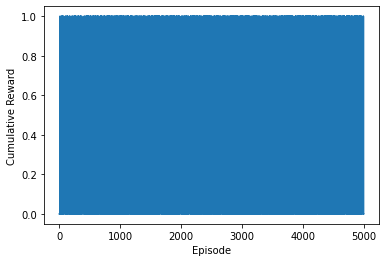

In [3]:
model, env = train_reinforce(stochastic=True, episodes=5000, gamma=1, alpha=0.0001, hidden=64)

In [4]:
model.print_state_values()


		 State Value
------------------------------------------------
-0.0625| 0.2462| 0.4336| 0.6659| 0.9068| 1.1526| 1.4030| 1.6533|
------------------------------------------------
 1.9036| 2.1547| 2.4067| 2.6614| 2.9161| 3.1708| 3.4255| 3.6801|
------------------------------------------------
 3.9348| 4.1895| 4.4442| 4.6988| 4.9535| 5.2082| 5.4629| 5.7176|
------------------------------------------------
 5.9722| 6.2269| 6.4816| 6.7363| 6.9909| 7.2456| 7.5003| 7.7550|
------------------------------------------------
 8.0097| 8.2643| 8.5190| 8.7737| 9.0284| 9.2831| 9.5377| 9.7924|
------------------------------------------------
 10.0471| 10.3018| 10.5564| 10.8111| 11.0658| 11.3205| 11.5752| 11.8298|
------------------------------------------------
 12.0845| 12.3392| 12.5939| 12.8486| 13.1032| 13.3579| 13.6126| 13.8673|
------------------------------------------------
 14.1219| 14.3766| 14.6313| 14.8860| 15.1407| 15.3953| 15.6500| 15.9047|
------------------------------------------------

In [5]:
model.print_policy()


		 Policy/Actions
------------------------------------------------
  n  |  n  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------
  r  |  r  |  r  |  r  |  r  |  r  |  r  |  r  |
------------------------------------------------


The return is greater than in the deterministic version; almost in all episodes, the agent could achieve the goal. The state value plot and the policy plot also confirm that the agent learned a similar behavior compared to the linear function approximators; however, in this case, the number of parameters and computing time decreases significantly. The neural network learned a complex dynamic by simply consuming the state without any prior information.

In [6]:
model.play()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFH

We also noted that the agent tries to hack the stochastic environment by moving to the walls in the expectation of reaching the desired state. Therefore, the immediate goal is to avoid the hole tiles, while hoping to reach the next best state. This is similar to all methods implemented in the stochastic environment. 

### 3.2) PPO (Arthur)

## 4) Discussion